In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import kagglehub
import matplotlib.pyplot as plt
# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
from tqdm import tqdm
import gdown

# from google.colab import drive
# drive.mount('/content/drive')

tqdm.pandas()

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# # Load data
# ciplab_real_and_fake_face_detection_path = kagglehub.dataset_download('ciplab/real-and-fake-face-detection')
# print('Data source import complete.')

In [ ]:
# download path
test_data_url = f'https://drive.google.com/1Eek6UGcnW0ElJ1vZmqtpUNqHi1QWojrX'
train_data_url = f'https://drive.google.com/1UPBQxchLmYXgGtdCn9MQeRaLE3-p_hAg'
val_data_url = f'https://drive.google.com/1HkPVxy41DeYPi7MGtJ-wjurub0KrXZI_'

file_dict = {
    "1Eek6UGcnW0ElJ1vZmqtpUNqHi1QWojrX": "test_data.csv",
    "1UPBQxchLmYXgGtdCn9MQeRaLE3-p_hAg": "train_data.csv",
    "1HkPVxy41DeYPi7MGtJ-wjurub0KrXZI_": "val_data.csv"
}

# download all
for file_id, output in file_dict.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"Downloading {output}...")
    gdown.download(url, output, quiet=False)

print("All files downloaded successfully!")

try:
    train_data = pd.read_csv("train_data.csv")
    val_data = pd.read_csv("val_data.csv")
    test_data = pd.read_csv("test_data.csv")
    # # randomly select 2000
    # new_data = new_data.sample(n=2000, random_state=42)  # 设定 random_state 以保证可复现

    # # index again
    # train_data.reset_index(drop=True, inplace=True)

    print(train_data.info())
    print(test_data.info())
    print(val_data.info())
    print(train_data.head().to_csv(sep='\t', na_rep='nan'))
    print(test_data.head().to_csv(sep='\t', na_rep='nan'))
    print(val_data.head().to_csv(sep='\t', na_rep='nan'))

except pd.errors.ParserError as e:
    print(f"Error at parsing: {e}")

Downloading...
From: https://drive.google.com/uc?id=1Eek6UGcnW0ElJ1vZmqtpUNqHi1QWojrX
To: /content/test_data.csv
100%|██████████| 2.67M/2.67M [00:00<00:00, 197MB/s]


Downloading...
From: https://drive.google.com/uc?id=1UPBQxchLmYXgGtdCn9MQeRaLE3-p_hAg
To: /content/train_data.csv
100%|██████████| 12.3M/12.3M [00:00<00:00, 131MB/s]


Downloading...
From: https://drive.google.com/uc?id=1HkPVxy41DeYPi7MGtJ-wjurub0KrXZI_
To: /content/val_data.csv
100%|██████████| 2.64M/2.64M [00:00<00:00, 224MB/s]


All files downloaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55517 entries, 0 to 55516
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_filename  55517 non-null  object 
 1   cluster_id      27727 non-null  float64
 2   region          55517 non-null  object 
 3   gender          55517 non-null  int64  
 4   ethnicity       55517 non-null  int64  
 5   age             55517 non-null  int64  
 6   age_bin         55517 non-null  object 
 7   label           55517 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_filename  12001 non-null  object 
 1   cluster_id      6046 non-null   float64
 2   region          12001 non-null  object 
 3   ge

First try with all data, check accuracies.



## DataFrame Making for the Data
*Content of the Datafarme***
1. Col Paths 'Image Absolute Path'
2. Col Real '1 if Real, 0 if Fake

## Exploreing the Data

In [ ]:
celeba_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print(f"CelebA download finished, path:{celeba_path}")

# Download 1M AI generated faces
fake_faces_path = kagglehub.dataset_download("dullaz/1m-ai-generated-faces-128x128")
print(f"Fake Faces download finished, path: {fake_faces_path}")

100%|██████████| 1.33G/1.33G [00:06<00:00, 238MB/s]

Extracting files...


CelebA 数据集下载完成，路径：/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


100%|██████████| 4.08G/4.08G [00:26<00:00, 164MB/s]

Extracting files...


Fake Faces 数据集下载完成，路径：/root/.cache/kagglehub/datasets/dullaz/1m-ai-generated-faces-128x128/versions/5


Train Data:                                       image_filename  cluster_id  \
0  /root/.cache/kagglehub/datasets/jessicali9530/...      1479.0   
1  /root/.cache/kagglehub/datasets/jessicali9530/...      8494.0   
2  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...         NaN   
3  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...         NaN   
4  /root/.cache/kagglehub/datasets/jessicali9530/...      5419.0   

                                              region  gender  ethnicity  age  \
0  {'x': 20, 'y': 58, 'w': 137, 'h': 137, 'left_e...       0          1   29   
1  {'x': 38, 'y': 74, 'w': 99, 'h': 99, 'left_eye...       1          1   45   
2  {'x': 0, 'y': 0, 'w': 127, 'h': 127, 'left_eye...       0          1   23   
3  {'x': 0, 'y': 0, 'w': 127, 'h': 127, 'left_eye...       0          0   26   
4  {'x': 26, 'y': 60, 'w': 127, 'h': 127, 'left_e...       1          1   54   

      age_bin  label  
0  below_mean      1  
1  above_mean      1  
2  below_mean      0  
3  bel

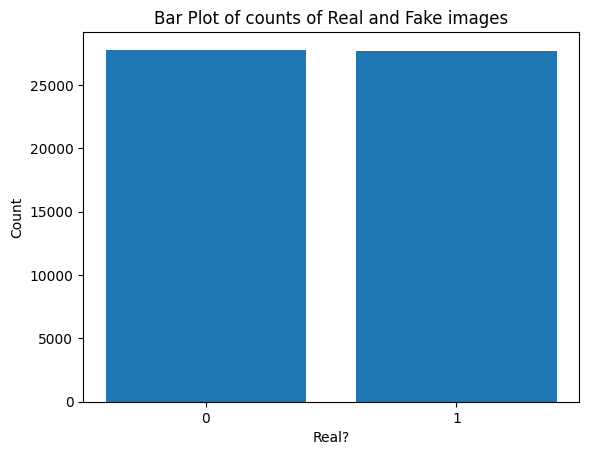

In [ ]:
#check data
print(f"Train Data: {train_data.head()}")
print(f"Train Data Size: {train_data.shape}")
print("-"*98)
print(f"Test Data: {test_data.head()}")
print(f"Test Data Size: {test_data.shape}")
print("-"*98)
print(f"Val Data: {val_data.head()}")
print(f"Val Data Size: {val_data.shape}")
print("-"*98)
#data visuals
# value_counts = MeregedDf.value_counts('Real')
# plt.bar(value_counts.index, value_counts.values)
# plt.xlabel('Real?')
# plt.ylabel('Count')
# plt.title('Bar Plot of counts of Real and Fake images')
# plt.xticks([0,1])
# plt.show()

value_counts = train_data.value_counts('label')
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Real?')
plt.ylabel('Count')
plt.title('Bar Plot of counts of Real and Fake images')
plt.xticks([0,1])
plt.show()

## Flatten & Normlize the Images
*Flatten the Images："Convert it from Matrix to Array of Values"*

*Normalize the Image "Convert Values to Be from 0 to 1"*

In [ ]:
# reshape to 128; make images array of 0 to 1.
def ProcessingImage(path, target_size=(128, 128), color_mode='rgb'):
    img = load_img(path, color_mode = color_mode, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array/255.0
    return img_array

train_data['image'] = train_data['image_filename'].apply(ProcessingImage)
print("Train Data Done")
test_data['image'] = test_data['image_filename'].apply(ProcessingImage)
print("Test Data Done")
val_data['image'] = val_data['image_filename'].apply(ProcessingImage)
print("Val Data Done")

Train Data Done
Test Data Done
Val Data Done


## Divide the Data to Training Data & Testing Data
1. Training Data are 80% of Data
2. Testing Data are 20% of Data

In [ ]:
# 80% train, 20% test
# TrainDf, TestDf = train_test_split(new_data, test_size=0.2, stratify=new_data['label'], random_state = 123)
TrainDf=train_data
TestDf=test_data
ValDf=val_data

XTrain = np.stack(TrainDf['image'].values)
YTrain = TrainDf['label'].values
XVal = np.stack(ValDf['image'].values)
YVal = ValDf['label'].values
XTest = np.stack(TestDf['image'].values)
YTest = TestDf['label'].values
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
#Random sampling
# # randomly select 2000 photos
# new_data = new_data.sample(n=2000, random_state=42)  # set random_state to make sure it's replicable

# # index again
# train_data.reset_index(drop=True, inplace=True)

(55517, 128, 128, 3)
(11882, 128, 128, 3)
(12001, 128, 128, 3)


## The Models Making Using CNNs
*Model 1*
1. Using SGD Optimizier

*Model 2*
1. Using ADAM Optimizier

*Model 1 & Model 2 are Using 6 Layers Arranged as*
1. Conv2D
2. MaxPooling 2D
3. Conv2D
4. MaxPooling 2D
5. Flatten  *It Is Not a Layer*
6. Relu "Activation Function"
7. Sigmoid "Activation Function" *Output Layer*

In [ ]:
#Adam and SGD initialize
def modelSGD():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def modelADAM():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Plotting the Performance Result the Model
# evaluate with loss and accuracy
def eval(results, model):
    plt.subplot(211)
    plt.subplots_adjust(hspace=0.4)
    plt.title('Cross Entropy Loss')
    plt.plot(results.history['loss'], color='blue', label='train')
    plt.plot(results.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(results.history['accuracy'], color='blue', label='train')
    plt.plot(results.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.legend()
    # loss, acc = model.evaluate(XTest, YTest, verbose=0)
    # print('Cross Entropy Loss: %.2f' % loss)
    # print('Validation Accuracy: %.2f%%' % (acc * 100.0))
    loss, acc = model.evaluate(XTest.cpu().numpy(), YTest.cpu().numpy(), verbose=0)

    print('Cross Entropy Loss: %.2f' % loss)
    print('Validation Accuracy: %.2f%%' % (acc * 100.0))

## Analysis of the Model Performance
## *Using*
## 1. Recall
## 2. Percision
## 3. Confusion Matrix
## 4. Accuerrcy
##analysis functions for future reference

def Analysis(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    metrics = ['Accuracy', 'Precision', 'Recall']
    scores = [accuracy, precision, recall]

    plt.bar(metrics, scores)

    for i, score in enumerate(scores):
        plt.text(i, score+0.02, f'{score:.2f}', ha='center', va='bottom', fontsize = 10)

    plt.ylim(0,1.1)
    plt.title('Accuracy, Precision and Recall Scores')
    plt.show()

    conf = confusion_matrix(true_labels, predicted_labels)
    labels = ['Real', 'Fake']

    conf_mat = ConfusionMatrixDisplay(conf, display_labels=labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    conf_mat.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    plt.show()

## Visual Sample of the Exsits Images with
1. Real Class
2. Expected Class

In [ ]:
# #visualize
# def VisualImages(Labels):
#     indices = np.random.choice(len(XTest), 10)

#     disp_img = XTest[indices]
#     disp_img_lab = YTest[indices]

#     fig, axes = plt.subplots(nrows=2, ncols = 5, figsize = (15,8))
#     fig.suptitle('Images with their Predicted and Actual Labels', fontsize=20)

#     for i, ax in enumerate(axes.flat):
#         ax.imshow(disp_img[i])
#         ax.axis('off')

#         actual_label = 'Real' if disp_img_lab[i] == 1 else 'Fake'
#         predicted_label = 'Real' if Labels[i] == 1 else 'Fake'
#         ax.set_title('Actual: ' +actual_label +'\n' + 'Predicted: ' + predicted_label)

#     plt.tight_layout()
#     plt.show()

# Base Model

## Model 1 "SGD"

In [ ]:
TrainDf, TestDf = train_test_split(new_data, test_size=0.2, stratify=new_data['label'], random_state = 123)

XTrain = np.stack(TrainDf['image'].values)
YTrain = TrainDf['label'].values
XTest = np.stack(TestDf['image'].values)
YTest = TestDf['label'].values

YTrain = YTrain.astype(np.float32)
YTest = YTest.astype(np.float32)
model_SGD = modelSGD()
model_SGD.summary()
history_SGD = model_SGD.fit(XTrain, YTrain, epochs=20, batch_size=32, validation_data=(XTest, YTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 128, 128, 3), dtype=float32). Expected shape (None, 768), but input has incompatible shape (32, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
#evaluate
print("Using SDG Optmizier")
eval(history_SGD, model_SGD)

In [ ]:
#result to matrix 0 to 1
SGDPredictions = model1.predict(XTest)
SGDPredictedLabels = np.round(SGDPredictions).flatten().astype(int)
SGDTrueLabels = np.round(YTest).flatten().astype(int)
# print(SGDPredictedLabels)
# print(SGDTrueLabels)
#precision：predicted real and actually real
#recall：total predicted as real
#accuracy：correctly predicted real and fake
Analysis(SGDTrueLabels,SGDPredictedLabels)

#A few examples
# VisualImages(SGDPredictedLabels)

## Model 2 "ADAM"

In [ ]:
model_ADAM = modelADAM()
model_ADAM.summary()
history_ADAM = model_ADAM.fit(XTrain, YTrain, epochs=20, batch_size=32, validation_data=(XTest, YTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,765,505 (56.33 MB)

 Trainable params: 14,765,505 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6579 - loss: 0.9262 - val_accuracy: 0.9425 - val_loss: 0.2806
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9605 - loss: 0.2107 - val_accuracy: 0.9750 - val_loss: 0.1289
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9870 - loss: 0.0938 - val_accuracy: 0.9900 - val_loss: 0.0664
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9955 - loss: 0.0481 - val_accuracy: 0.9925 - val_loss: 0.0547
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 0.9925 - val_loss: 0.0403
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.9900 - val_loss: 0.0310
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9875 - val_loss: 0.0266
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.9925 - v

Using ADAM Optmizier


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

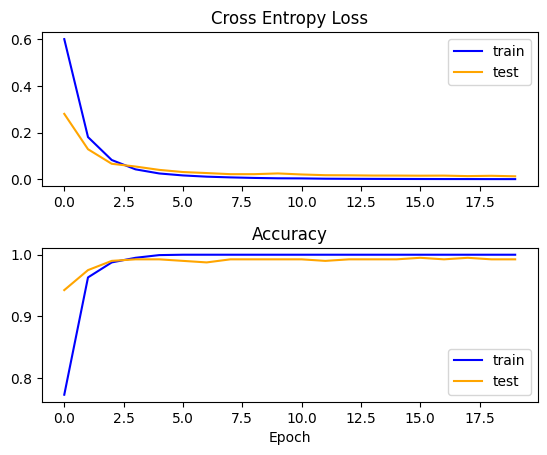

In [ ]:
print("Using ADAM Optmizier")
eval(history_ADAM, model_ADAM)

In [ ]:
ADAMPredictions = model_ADAM.predict(XTest)
ADAMPredictedLabels = np.round(ADAMPredictions).flatten().astype(int)
ADAMTrueLabels = np.round(YTest).flatten().astype(int)
# print(ADAMPredictedLabels[:10])
# print(ADAMTrueLabels[:10])

Analysis(ADAMTrueLabels,ADAMPredictedLabels)

# VisualImages(SGDPredictedLabels)

# ADAM + more features


## Test DinoV2 for SGD + ADAM

In [ ]:
def load_dinov2_model(model_name="facebook/dinov2-base", device='cuda' if torch.cuda.is_available() else 'cpu'):
    """load dinov2 model and image processor"""
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = Dinov2Model.from_pretrained(model_name)
    model.eval()  # eval mode
    model.to(device)
    return processor, model, device

def extract_dinov2_features(image_path, processor, model, device):
    """extract dinov2 features"""
    # load and preprocess images
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)

    # extract features
    with torch.no_grad():
        outputs = model(**inputs)
    # get[CLS] token features (dimension 768)
    features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return features.flatten()  # returned datasets
def ProcessingImage_dinov2(path, processor, model, device):
    """extract image features with dinov2"""
    features = extract_dinov2_features(path, processor, model, device)
    return features

# change model infra to adjust dinov2 feature (input dimension 768)
def modelSGD_dinov2(input_dim=768):
    model = Sequential()
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(input_dim,)))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def modelADAM_dinov2(input_dim=768):
    model = Sequential()
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(input_dim,)))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load dinoV2 model
processor, model, device = load_dinov2_model()

# # Extract features with DinoV2
# TrainDf['image'] = Df['Paths'].apply(lambda x: ProcessingImage_dinov2(x, processor, model, device))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_device_name = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {tf_device_name}")

# **Extract features with DinoV2**
print("Extracting DINOv2 features for train_data, val_data, and test_data...")

train_data['image'] = train_data['image_filename'].progress_apply(lambda x: ProcessingImage_dinov2(x, processor, model, device))
val_data['image'] = val_data['image_filename'].progress_apply(lambda x: ProcessingImage_dinov2(x, processor, model, device))
test_data['image'] = test_data['image_filename'].progress_apply(lambda x: ProcessingImage_dinov2(x, processor, model, device))
print("Feature extraction completed.")

Using device: /GPU:0
Extracting DINOv2 features for train_data, val_data, and test_data...


100%|██████████| 12001/12001 [02:20<00:00, 85.50it/s]


In [ ]:
XTrain_full = np.vstack(train_data['image'].values)
YTrain_full = train_data['label'].values
XVal = np.vstack(val_data['image'].values)
YVal = val_data['label'].values
XTest = np.vstack(test_data['image'].values)
YTest = test_data['label'].values

# **Set different sample sizes**
train_sizes = [200, 500, 1000, 2000, 5000, 10000, 20000, len(train_data)]

# **store training results**
histories = {}

# **Train with different sample sizes**
with tf.device(tf_device_name):
    for size in train_sizes:
        print(f"\nTraining with {size} samples...")
        if size == len(train_data):
          XTrain_sub, YTrain_sub = XTrain_full, YTrain_full  # all data
        else:
          train_ratio = min(size / len(XTrain_full), 0.99)
          XTrain_sub, _, YTrain_sub, _ = train_test_split(
              XTrain_full, YTrain_full,
              train_size=train_ratio,
              stratify=YTrain_full,
              random_state=123
          )

        # **transfer to PyTorch Tensor**
        XTrain_sub_dinov2 = torch.tensor(XTrain_sub, dtype=torch.float32, device=device)
        YTrain_sub = torch.tensor(YTrain_sub, dtype=torch.float32, device=device)

        # **Define MLP model**
        def modelADAM_dinov2(input_dim=768):
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(input_dim,)),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
            opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
            return model

        # **initialize & train model**
        model = modelADAM_dinov2(input_dim=XTrain_sub_dinov2.shape[1])
        model.summary()

        # **training**
        history_key = f"history_ADAM_dinov2_{size}"
        histories[history_key] = model.fit(
            XTrain_sub_dinov2.cpu().numpy(),
            YTrain_sub.cpu().numpy(),
            epochs=20,
            batch_size=32,
            validation_data=(XVal, YVal)
        )


Training with 200 samples...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5205 - loss: 1.0365 - val_accuracy: 0.6410 - val_loss: 0.7111
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7071 - loss: 0.6025 - val_accuracy: 0.7210 - val_loss: 0.5704
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8317 - loss: 0.3993 - val_accuracy: 0.7665 - val_loss: 0.4894
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9188 - loss: 0.2855 - val_accuracy: 0.7952 - val_loss: 0.4411
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9157 - loss: 0.2409 - val_accuracy: 0.8165 - val_loss: 0.4030
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9497 - loss: 0.1817 - val_accuracy: 0.8279 - val_loss: 0.3788
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9588 - loss: 0.1651 - val_accuracy: 0.8350 - val_loss: 0.3641
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9822 - loss: 0.1028 - val_accuracy: 0.8417 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5493 - loss: 0.8185 - val_accuracy: 0.7429 - val_loss: 0.5418
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7734 - loss: 0.4350 - val_accuracy: 0.8106 - val_loss: 0.4225
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8633 - loss: 0.3078 - val_accuracy: 0.8352 - val_loss: 0.3731
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9200 - loss: 0.2170 - val_accuracy: 0.8552 - val_loss: 0.3346
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9206 - loss: 0.1888 - val_accuracy: 0.8671 - val_loss: 0.3104
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9724 - loss: 0.1414 - val_accuracy: 0.8743 - val_loss: 0.2958
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9757 - loss: 0.1161 - val_accuracy: 0.8786 - val_loss: 0.2847
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9939 - loss: 0.0936 - val_accuracy: 0.8848 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6694 - loss: 0.6606 - val_accuracy: 0.8412 - val_loss: 0.3582
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8750 - loss: 0.2891 - val_accuracy: 0.8812 - val_loss: 0.2817
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9245 - loss: 0.2116 - val_accuracy: 0.9003 - val_loss: 0.2422
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9575 - loss: 0.1547 - val_accuracy: 0.9105 - val_loss: 0.2201
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9683 - loss: 0.1245 - val_accuracy: 0.9229 - val_loss: 0.1981
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9842 - loss: 0.1025 - val_accuracy: 0.9256 - val_loss: 0.1883
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9885 - loss: 0.0804 - val_accuracy: 0.9309 - val_loss: 0.1786
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9913 - loss: 0.0704 - val_accuracy: 0.9333 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7089 - loss: 0.5961 - val_accuracy: 0.8737 - val_loss: 0.2960
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9024 - loss: 0.2461 - val_accuracy: 0.9131 - val_loss: 0.2179
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9401 - loss: 0.1671 - val_accuracy: 0.9262 - val_loss: 0.1873
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9561 - loss: 0.1255 - val_accuracy: 0.9336 - val_loss: 0.1668
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9708 - loss: 0.0995 - val_accuracy: 0.9415 - val_loss: 0.1518
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9749 - loss: 0.0895 - val_accuracy: 0.9453 - val_loss: 0.1402
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9882 - loss: 0.0648 - val_accuracy: 0.9493 - val_loss: 0.1322
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9920 - loss: 0.0532 - val_accuracy: 0.9519 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7212 - loss: 0.7273 - val_accuracy: 0.9064 - val_loss: 0.2230
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9278 - loss: 0.1834 - val_accuracy: 0.9368 - val_loss: 0.1621
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9578 - loss: 0.1217 - val_accuracy: 0.9512 - val_loss: 0.1282
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9709 - loss: 0.0907 - val_accuracy: 0.9583 - val_loss: 0.1111
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9835 - loss: 0.0660 - val_accuracy: 0.9637 - val_loss: 0.0990
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9847 - loss: 0.0551 - val_accuracy: 0.9658 - val_loss: 0.0927
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9921 - loss: 0.0398 - val_accuracy: 0.9694 - val_loss: 0.0869
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9959 - loss: 0.0361 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8053 - loss: 0.4172 - val_accuracy: 0.9502 - val_loss: 0.1345
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9645 - loss: 0.1053 - val_accuracy: 0.9673 - val_loss: 0.0970
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9801 - loss: 0.0635 - val_accuracy: 0.9731 - val_loss: 0.0757
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0490 - val_accuracy: 0.9742 - val_loss: 0.0682
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9907 - loss: 0.0364 - val_accuracy: 0.9789 - val_loss: 0.0575
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9951 - loss: 0.0270 - val_accuracy: 0.9793 - val_loss: 0.0562
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9955 - loss: 0.0207 - val_accuracy: 0.9797 - val_loss: 0.0520
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9978 - loss: 0.0167 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8744 - loss: 0.2787 - val_accuracy: 0.9700 - val_loss: 0.0845
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9769 - loss: 0.0671 - val_accuracy: 0.9806 - val_loss: 0.0597
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9872 - loss: 0.0436 - val_accuracy: 0.9833 - val_loss: 0.0466
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9929 - loss: 0.0286 - val_accuracy: 0.9848 - val_loss: 0.0411
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9964 - loss: 0.0192 - val_accuracy: 0.9873 - val_loss: 0.0372
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9975 - loss: 0.0145 - val_accuracy: 0.9887 - val_loss: 0.0316
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9992 - loss: 0.0102 - val_accuracy: 0.9870 - val_loss: 0.0328
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9995 - loss: 0.0081 - val_accuracy: 0.

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9191 - loss: 0.1913 - val_accuracy: 0.9821 - val_loss: 0.0516
Epoch 2/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9879 - loss: 0.0377 - val_accuracy: 0.9871 - val_loss: 0.0345
Epoch 3/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9938 - loss: 0.0223 - val_accuracy: 0.9908 - val_loss: 0.0260
Epoch 4/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9964 - loss: 0.0132 - val_accuracy: 0.9919 - val_loss: 0.0235
Epoch 5/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 0.9928 - val_loss: 0.0215
Epoch 6/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9989 - loss: 0.0062 - val_accuracy: 0.9916 - val_loss: 0.0242
Epoch 7/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 0.9933 - val_loss: 0.0193
Epoch 8/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9995 - loss: 0.0033 - 

In [ ]:
# Use tqdm to minitor apply progress
new_data['image'] = new_data['image_filename'].progress_apply(lambda x: ProcessingImage_dinov2(x, processor, model, device))
# 80%train, 20% test
TrainDf, TestDf = train_test_split(new_data, test_size=0.2, stratify=new_data['label'], random_state=123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transfer to PyTorch Tensor and move to GPU
# transfer numpy to Tensor
XTrain_dinov2 = torch.tensor(np.vstack(TrainDf['image'].values), dtype=torch.float32, device=device)
YTrain = torch.tensor(TrainDf['label'].values, dtype=torch.float32, device=device)

XTest_dinov2 = torch.tensor(np.vstack(TestDf['image'].values), dtype=torch.float32, device=device)
YTest = torch.tensor(TestDf['label'].values, dtype=torch.float32, device=device)

In [ ]:
# GPU def and train
with tf.device(device_name):
    def modelADAM_dinov2(input_dim=768):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(input_dim,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # ensure XTrain_dinov2 is correct
    modelADAM_dinov2 = modelADAM_dinov2(input_dim=XTrain_dinov2.shape[1])
    modelADAM_dinov2.summary()

    # train model
    history_ADAM_dinov2 = modelADAM_dinov2.fit(
        XTrain_dinov2.cpu().numpy(),  # change to NumPy
        YTrain.cpu().numpy(),
        epochs=20,
        batch_size=32,
        validation_data=(XTest_dinov2.cpu().numpy(), YTest.cpu().numpy())
    )

# modelSGD_dinov2 = modelSGD_dinov2(input_dim=XTrain_dinov2.shape[1])
# modelSGD_dinov2.summary()
# history_SGD_dinov2 = modelSGD_dinov2.fit(XTrain_dinov2, YTrain, epochs=20, batch_size=32, validation_data=(XTest_dinov2, YTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using device: /GPU:0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6679 - loss: 0.6631 - val_accuracy: 0.8500 - val_loss: 0.3149
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9001 - loss: 0.2481 - val_accuracy: 0.9025 - val_loss: 0.2361
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9388 - loss: 0.1777 - val_accuracy: 0.9125 - val_loss: 0.1959
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.1457 - val_accuracy: 0.9350 - val_loss: 0.1733
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9711 - loss: 0.1049 - val_accuracy: 0.9400 - val_loss: 0.1595
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0943 - val_accuracy: 0.9400 - val_loss: 0.1466
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0726 - val_accuracy: 0.9400 - val_loss: 0.1427
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0575 - val_accuracy: 0.9450 - val_loss

In [ ]:
# modelADAM_dinov2 = modelADAM_dinov2()
# modelADAM_dinov2.summary()
# history_ADAM_dinov2 = modelADAM_dinov2.fit(XTrain_dinov2, YTrain, epochs=20, batch_size=32, validation_data=(XTest_dinov2, YTest))

TypeError: missing a required argument: 'inputs'

In [ ]:
def eval_new(results, model):
    # result display
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # adjust shape
    plt.subplots_adjust(hspace=0.4)  # subsplots spaces change

    # First chart: loss
    axes[0].plot(results.history['loss'], color='blue', label='train')
    axes[0].plot(results.history['val_loss'], color='orange', label='val')
    axes[0].set_title('Cross Entropy Loss')
    axes[0].legend()

    # second chart: Accuracy
    axes[1].plot(results.history['accuracy'], color='blue', label='train')
    axes[1].plot(results.history['val_accuracy'], color='orange', label='val')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    # output
    loss, acc = model.evaluate(XTest, YTest, verbose=0)
    print('Test Cross Entropy Loss: %.2f' % loss)
    return loss, acc

eval and analysis

Using ADAM + DINOv2 for different training sizes

Evaluating model trained with 200 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


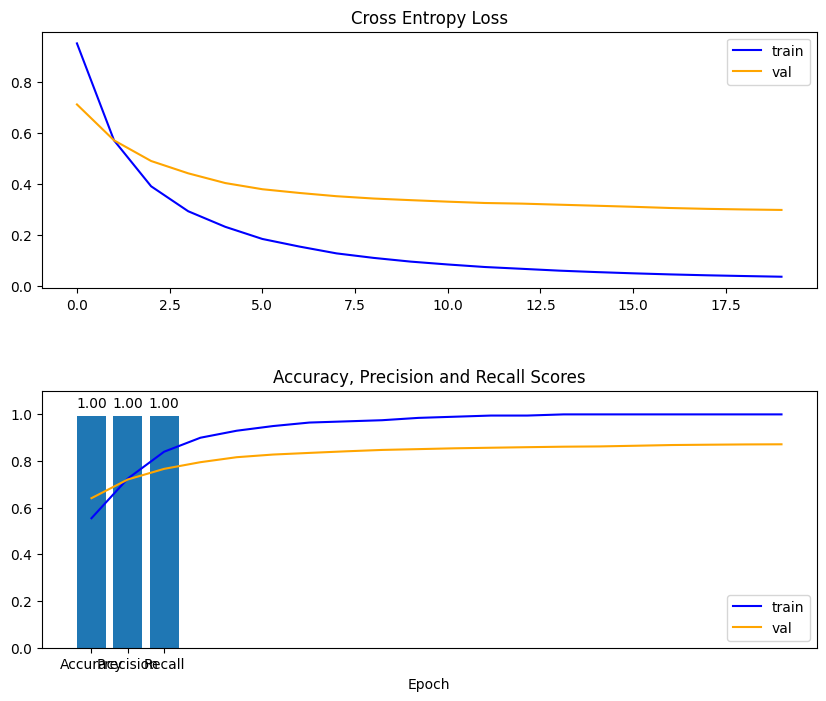

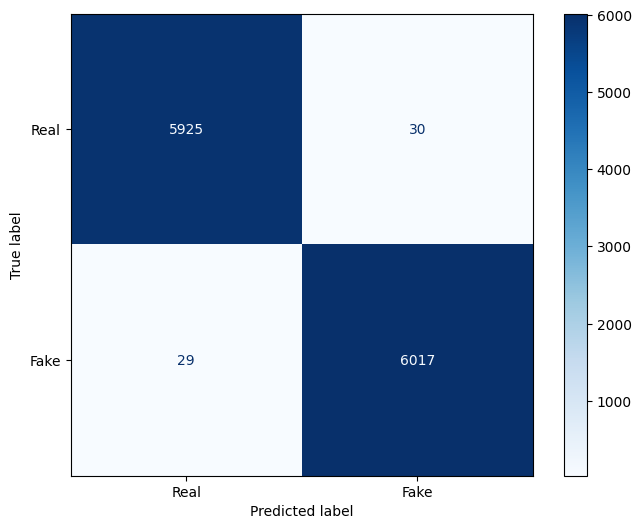


Evaluating model trained with 500 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


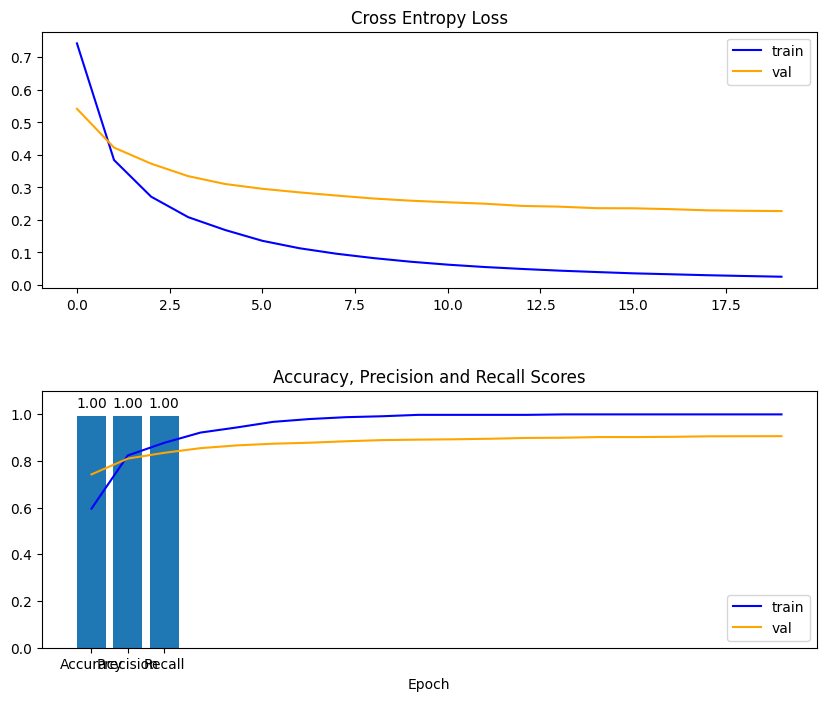

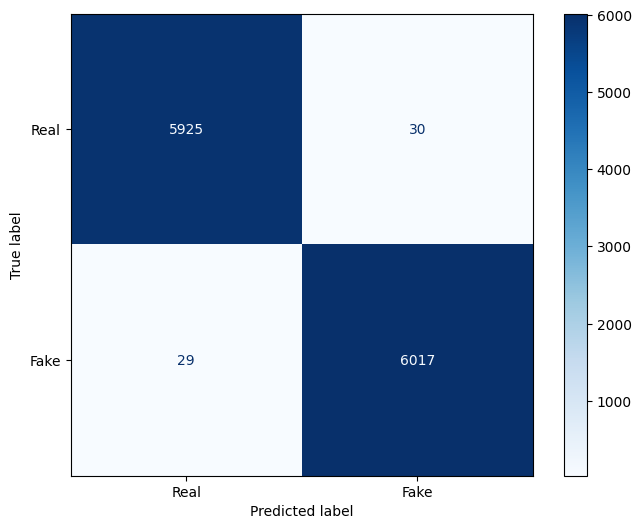


Evaluating model trained with 1000 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


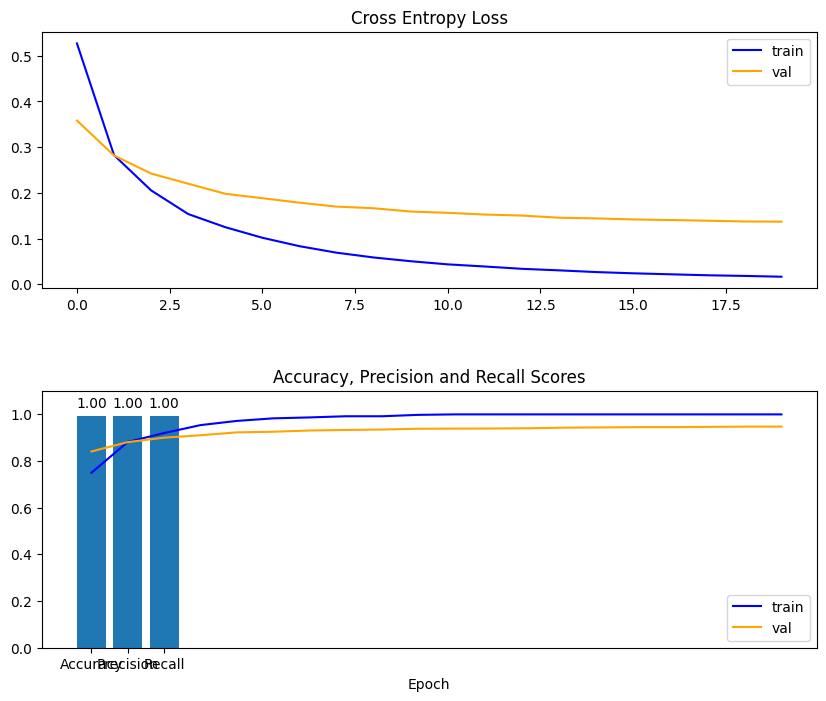

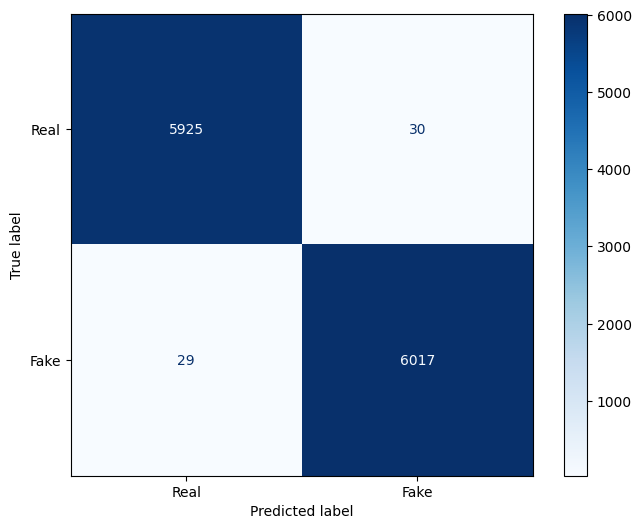


Evaluating model trained with 2000 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


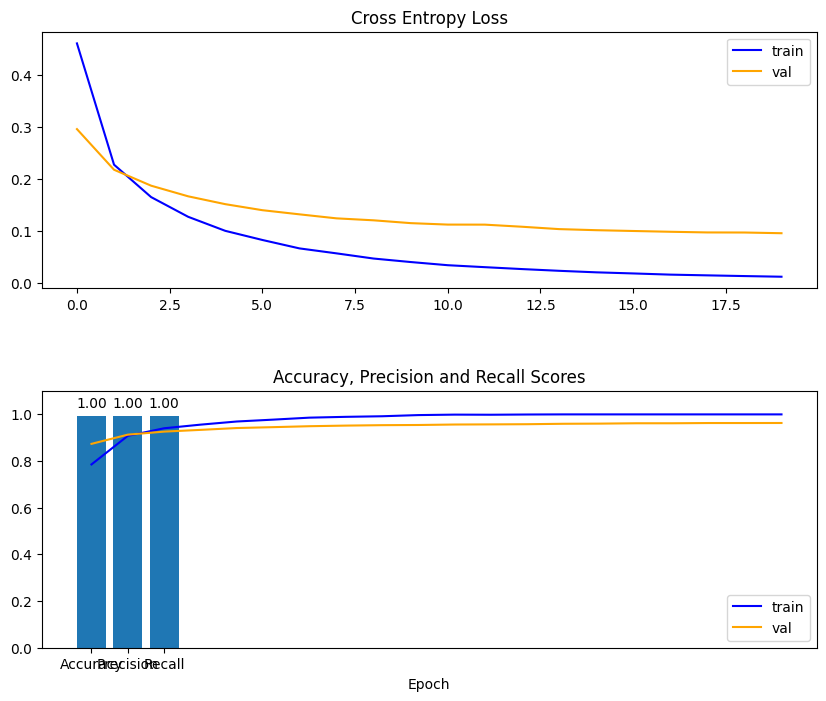

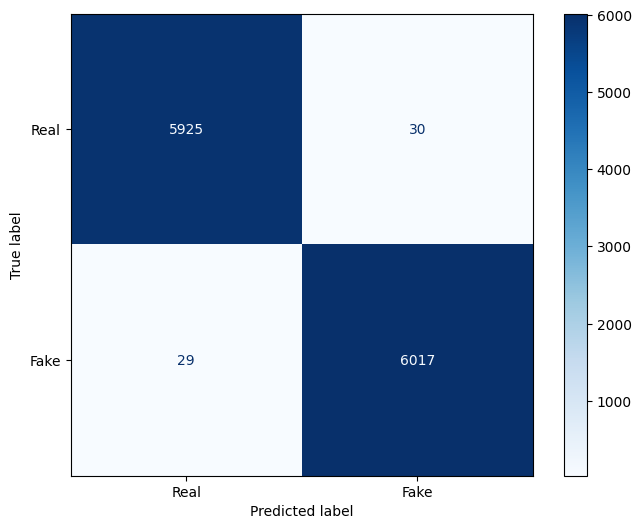


Evaluating model trained with 5000 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


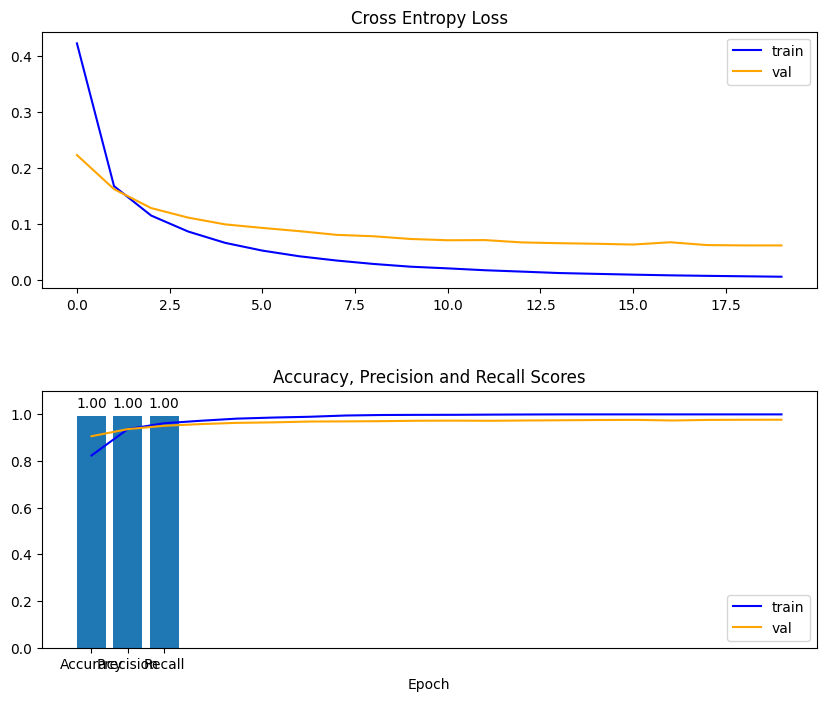

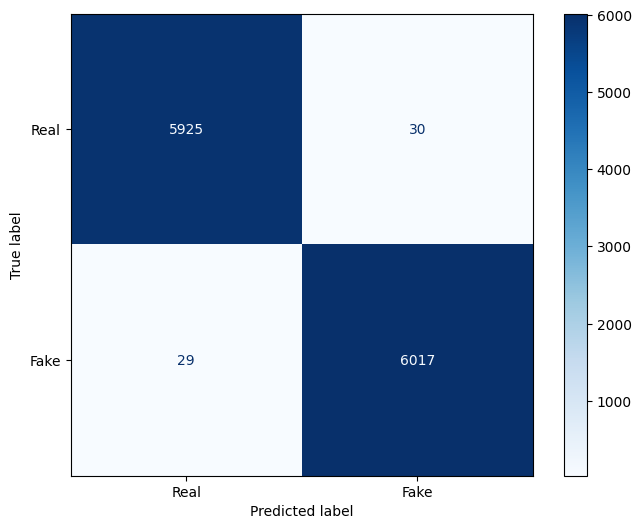


Evaluating model trained with 10000 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


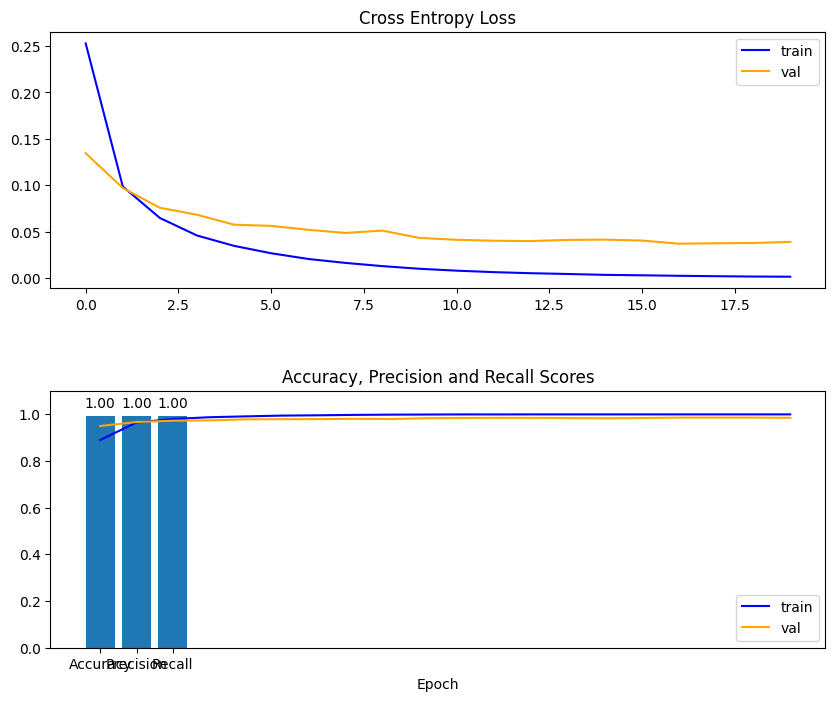

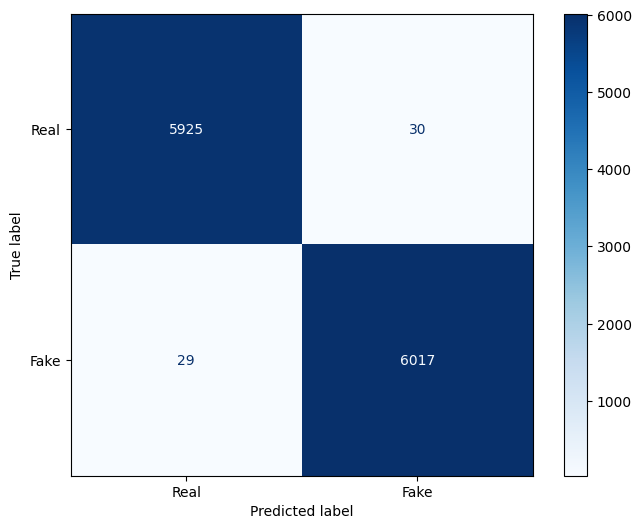


Evaluating model trained with 20000 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


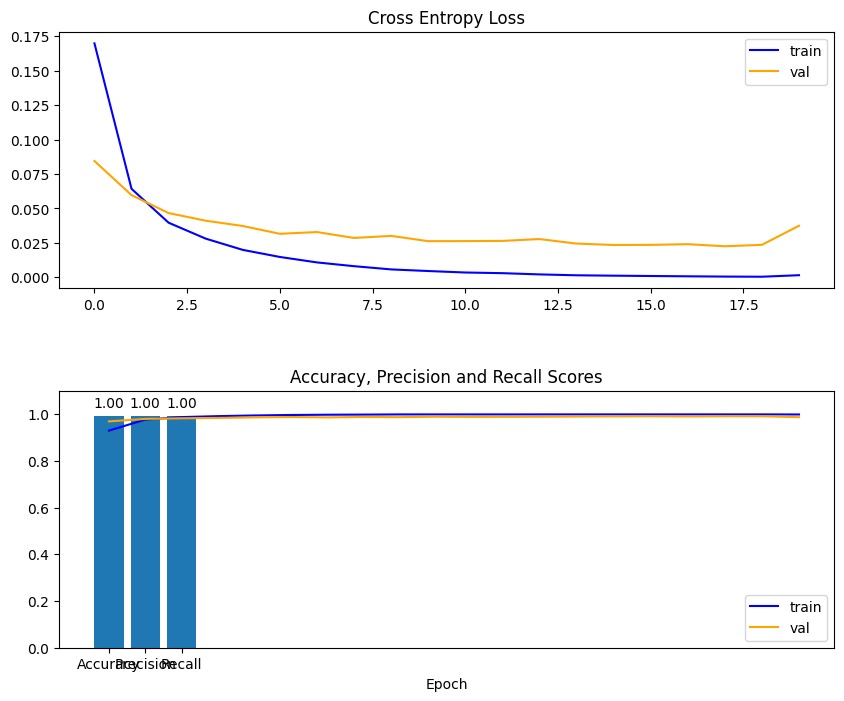

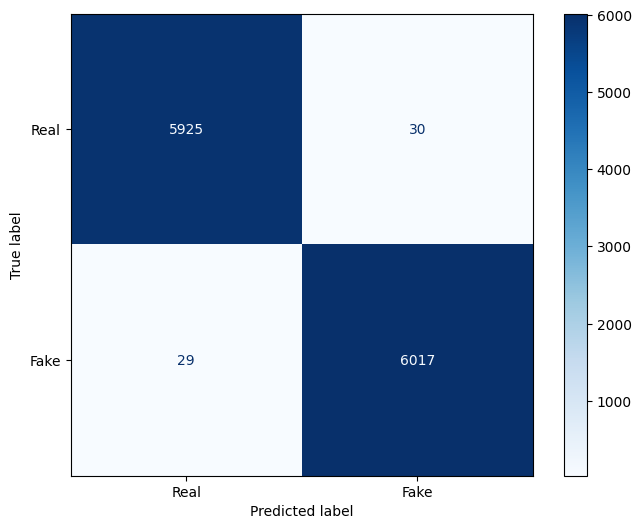


Evaluating model trained with 55517 samples...
Test Cross Entropy Loss: 0.02
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


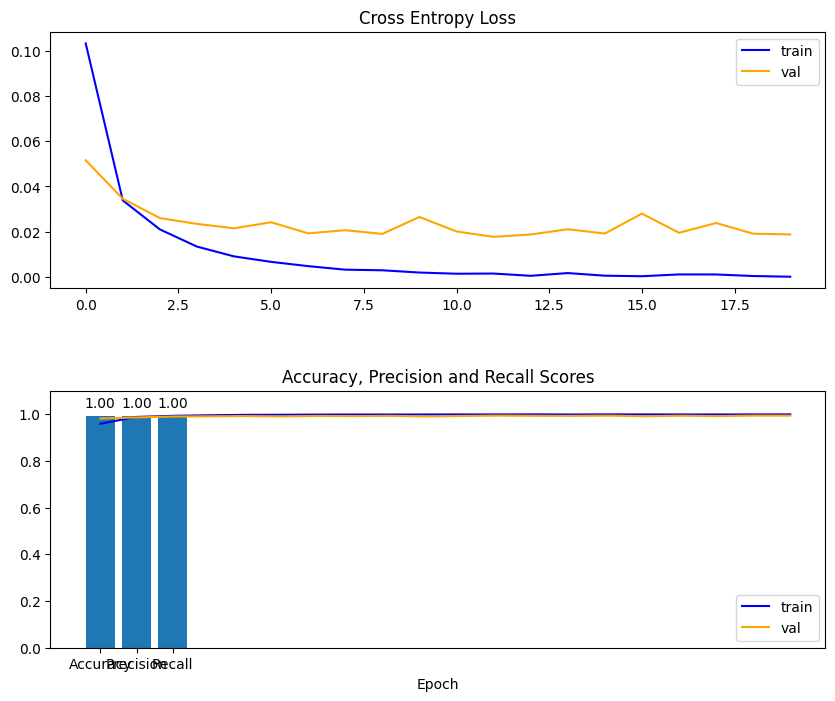

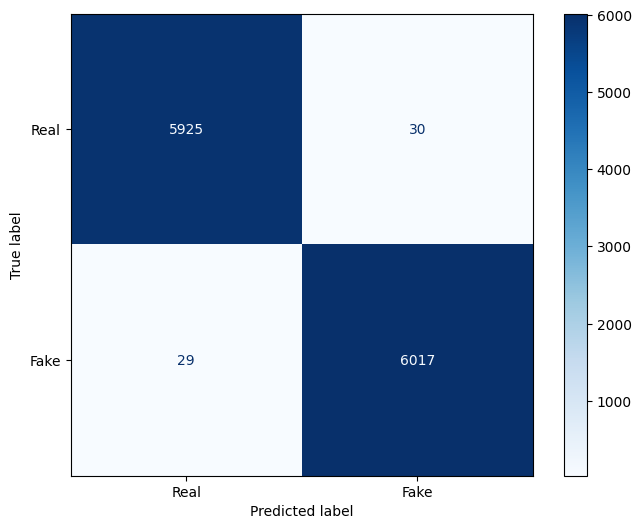


All evaluations and analyses completed.


In [ ]:
print("Using ADAM + DINOv2 for different training sizes")

# store all results
ADAM_dinov2_results = {}

for size in train_sizes:
    history_key = f"history_ADAM_dinov2_{size}"
    model_key = f"model_ADAM_dinov2_{size}"

    print(f"\nEvaluating model trained with {size} samples...")

    # **model eval**
    eval_new(histories[history_key], model)

    # **predictions**
    ADAMPredictions = model.predict(XTest)
    ADAMPredictedLabels = np.round(ADAMPredictions).flatten().astype(int)
    ADAMTrueLabels = np.round(YTest).flatten().astype(int)

    # **store results**
    ADAM_dinov2_results[size] = {
        "Predictions": ADAMPredictions,
        "PredictedLabels": ADAMPredictedLabels,
        "TrueLabels": ADAMTrueLabels
    }

    # **analyze**
    Analysis(ADAMTrueLabels, ADAMPredictedLabels)

print("\nAll evaluations and analyses completed.")


In [ ]:
print("Using SGD + Dinov2")
eval(history_SGD_dinov2, modelSGD_dinov2)
SGDPredictions = modelSGD_dinov2.predict(XTest)
SGDPredictedLabels = np.round(SGDPredictions).flatten().astype(int)
SGDTrueLabels = np.round(YTest).flatten().astype(int)

In [ ]:
Analysis(SGDTrueLabels,SGDPredictedLabels)

Using ADAM + Dinov2


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

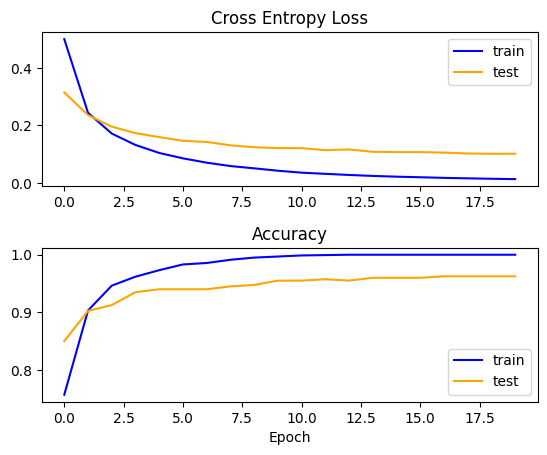

In [ ]:
print("Using ADAM + Dinov2")
eval(history_ADAM_dinov2, modelADAM_dinov2)
ADAMPredictions = modelADAM_dinov2.predict(XTest)
ADAMPredictedLabels = np.round(ADAMPredictions).flatten().astype(int)
ADAMTrueLabels = np.round(YTest).flatten().astype(int)

In [ ]:
Analysis(ADAMTrueLabels,ADAMPredictedLabels)